# L13: Training Deep Neural Networks
[1. Setup](#1.-Setup)\
[2. Vanishing/Exploding Gradients Problem](#2.-Vanishing/Exploding-Gradients-Problem)\
[3. Faster Optimizers](#3.-Faster-Optimizers)\
[4. Learning Rate Scheduling](#4.-Learning-Rate-Scheduling)

# 1. Setup

Install `TensorFlow` (only need to run once)

In [1]:
# pip install tensorflow

Import `TensorFlow`

In [2]:
import tensorflow as tf

Define the default font sizes to make the figures prettier

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Create the `images/deep` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 2. Vanishing/Exploding Gradients Problem

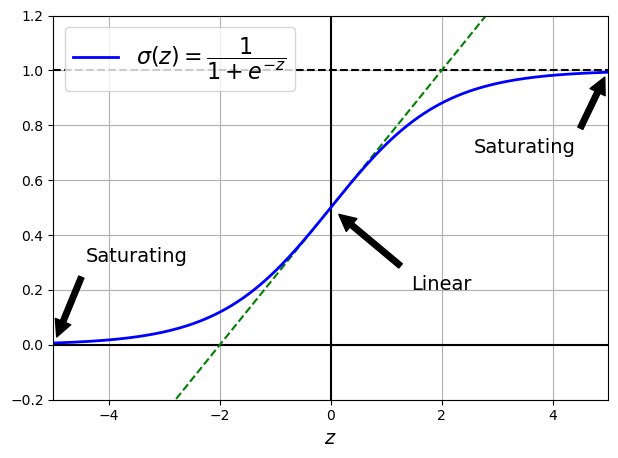

In [5]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Glorot and He Initialization
By default, Keras uses Glorot initialization with a uniform distribution\
When you create a layer, you can switch to He initialization by setting `kernel_initializer="he_uniform"` or `kernel_initializer="he_normal"` like this:

In [6]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

## Nonsaturating Activation Functions

### Leaky ReLU

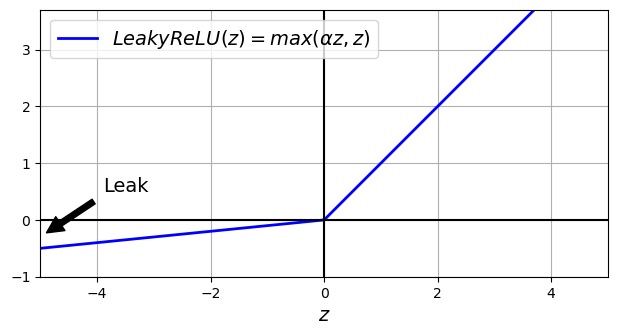

In [7]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [8]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

If you prefer, you can also use `LeakyReLU` as a separate layer in your model; it makes no difference for training and predictions:

In [9]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [10]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

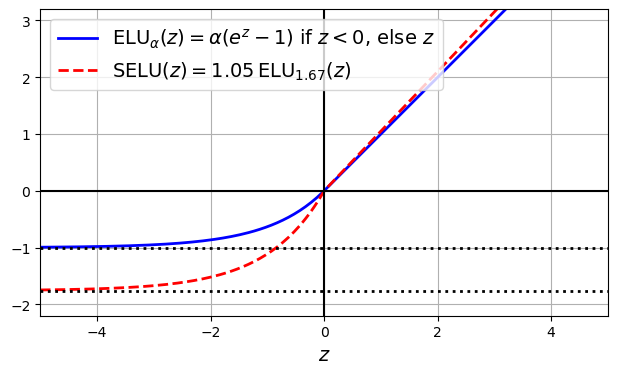

In [11]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [12]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**Extra material – an example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [13]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [15]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [16]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [17]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [18]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


1719/1719 [==============================] - 32s 15ms/step - loss: 1.0644 - accuracy: 0.5898 - val_loss: 0.7616 - val_accuracy: 0.7362
Epoch 2/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.6981 - accuracy: 0.7491 - val_loss: 0.6214 - val_accuracy: 0.7750
Epoch 3/5
1719/1719 [==============================] - 23s 14ms/step - loss: 0.6715 - accuracy: 0.7578 - val_loss: 0.5882 - val_accuracy: 0.7960
Epoch 4/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.6041 - accuracy: 0.7871 - val_loss: 0.6598 - val_accuracy: 0.7910
Epoch 5/5
1719/1719 [==============================] - 23s 14ms/step - loss: 0.5998 - accuracy: 0.7951 - val_loss: 0.5677 - val_accuracy: 0.8074


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [19]:
tf.random.set_seed(42)

In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [22]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 30s 13ms/step - loss: 1.9464 - accuracy: 0.2123 - val_loss: 1.5499 - val_accuracy: 0.3444
Epoch 2/5
1719/1719 [==============================] - 21s 12ms/step - loss: 1.3494 - accuracy: 0.4394 - val_loss: 1.0306 - val_accuracy: 0.5712
Epoch 3/5
1719/1719 [==============================] - 21s 12ms/step - loss: 1.0988 - accuracy: 0.5480 - val_loss: 1.2542 - val_accuracy: 0.4966
Epoch 4/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.9481 - accuracy: 0.6377 - val_loss: 1.0502 - val_accuracy: 0.6478
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.8698 - accuracy: 0.6693 - val_loss: 0.7847 - val_accuracy: 0.7068


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

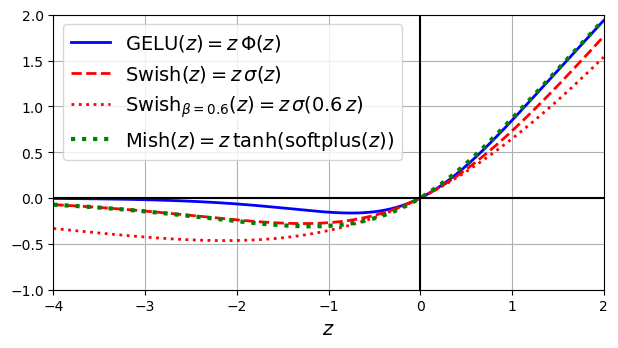

In [23]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

# Batch Normalization

In [24]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [27]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [28]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))


Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5507 - accuracy: 0.8098 - val_loss: 0.4059 - val_accuracy: 0.8532
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4057 - accuracy: 0.8559 - val_loss: 0.3608 - val_accuracy: 0.8628


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [29]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [31]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6114 - accuracy: 0.7955 - val_loss: 0.4405 - val_accuracy: 0.8438
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4264 - accuracy: 0.8499 - val_loss: 0.3754 - val_accuracy: 0.8602


## Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [32]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [33]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [34]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 4s 3ms/step - loss: 1.1266 - accuracy: 0.6513 - val_loss: 0.6698 - val_accuracy: 0.8030
Epoch 2/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.5796 - accuracy: 0.8245 - val_loss: 0.4970 - val_accuracy: 0.8438
Epoch 3/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.4674 - accuracy: 0.8543 - val_loss: 0.4277 - val_accuracy: 0.8601
Epoch 4/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.4117 - accuracy: 0.8681 - val_loss: 0.3871 - val_accuracy: 0.8706
Epoch 5/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3773 - accuracy: 0.8782 - val_loss: 0.3606 - val_accuracy: 0.8754
Epoch 6/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3532 - accuracy: 0.8840 - val_loss: 0.3449 - val_accuracy: 0.8779
Epoch 7/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.3360 - accuracy: 0.8887 - val_loss: 0.3295 - val_accuracy:

INFO:tensorflow:Assets written to: my_model_A\assets


In [35]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 51ms/step - loss: 0.6956 - accuracy: 0.5150 - val_loss: 0.6913 - val_accuracy: 0.5460
Epoch 2/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6710 - accuracy: 0.5800 - val_loss: 0.6700 - val_accuracy: 0.6004
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.6513 - accuracy: 0.6500 - val_loss: 0.6525 - val_accuracy: 0.6528
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6334 - accuracy: 0.6950 - val_loss: 0.6370 - val_accuracy: 0.7003
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6184 - accuracy: 0.7550 - val_loss: 0.6214 - val_accuracy: 0.7517
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.6033 - accuracy: 0.7900 - val_loss: 0.6074 - val_accuracy: 0.7893
Epoch 7/20
7/7 [==============================] - 0s 13ms/step - loss: 0.5896 - accuracy: 0.8200 - val_loss: 0.5938 - val_accuracy: 0.8249
Epoch 8/20
7/7 [===========

[0.4807088077068329, 0.9244999885559082]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [36]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [37]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

In [38]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [39]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [40]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [41]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 42ms/step - loss: 0.5367 - accuracy: 0.8050 - val_loss: 0.5275 - val_accuracy: 0.8803
Epoch 2/4
7/7 [==============================] - 0s 14ms/step - loss: 0.5167 - accuracy: 0.8800 - val_loss: 0.5168 - val_accuracy: 0.8843
Epoch 3/4
7/7 [==============================] - 0s 15ms/step - loss: 0.5084 - accuracy: 0.8900 - val_loss: 0.5120 - val_accuracy: 0.8902
Epoch 4/4
7/7 [==============================] - 0s 14ms/step - loss: 0.4960 - accuracy: 0.8850 - val_loss: 0.5003 - val_accuracy: 0.8952
Epoch 1/16
7/7 [==============================] - 1s 39ms/step - loss: 0.4724 - accuracy: 0.9100 - val_loss: 0.4535 - val_accuracy: 0.9100
Epoch 2/16
7/7 [==============================] - 0s 14ms/step - loss: 0.4292 - accuracy: 0.9400 - val_loss: 0.4140 - val_accuracy: 0.9288
Epoch 3/16
7/7 [==============================] - 0s 15ms/step - loss: 0.3921 - accuracy: 0.9500 - val_loss: 0.3893 - val_accuracy: 0.9199
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [42]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.2516 - accuracy: 0.9410


[0.25161051750183105, 0.9409999847412109]

# 3. Faster Optimizers

In [43]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [44]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [45]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7225 - accuracy: 0.7510 - val_loss: 0.5114 - val_accuracy: 0.8176
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4712 - accuracy: 0.8348 - val_loss: 0.4544 - val_accuracy: 0.8372
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4257 - accuracy: 0.8496 - val_loss: 0.4151 - val_accuracy: 0.8514
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3965 - accuracy: 0.8601 - val_loss: 0.3810 - val_accuracy: 0.8608
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3747 - accuracy: 0.8661 - val_loss: 0.3653 - val_accuracy: 0.8622
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3601 - accuracy: 0.8710 - val_loss: 0.3661 - val_accuracy: 0.8674
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3438 - accuracy: 0.8755 - val_loss: 0.3572 - val_accuracy:

## Momentum optimization

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [47]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6961 - accuracy: 0.7697 - val_loss: 0.4998 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4669 - accuracy: 0.8361 - val_loss: 0.4652 - val_accuracy: 0.8290
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4235 - accuracy: 0.8501 - val_loss: 0.4085 - val_accuracy: 0.8538
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3957 - accuracy: 0.8600 - val_loss: 0.3803 - val_accuracy: 0.8622
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3740 - accuracy: 0.8677 - val_loss: 0.3712 - val_accuracy: 0.8638
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3606 - accuracy: 0.8712 - val_loss: 0.3689 - val_accuracy: 0.8696
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3431 - accuracy: 0.8756 - val_loss: 0.3615 - val_accuracy:

## Nesterov Accelerated Gradient

In [48]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [49]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6950 - accuracy: 0.7621 - val_loss: 0.4881 - val_accuracy: 0.8224
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4609 - accuracy: 0.8378 - val_loss: 0.4403 - val_accuracy: 0.8412
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4161 - accuracy: 0.8531 - val_loss: 0.3974 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3907 - accuracy: 0.8619 - val_loss: 0.3802 - val_accuracy: 0.8632
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3696 - accuracy: 0.8681 - val_loss: 0.3732 - val_accuracy: 0.8652
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3559 - accuracy: 0.8717 - val_loss: 0.3700 - val_accuracy: 0.8660
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3406 - accuracy: 0.8766 - val_loss: 0.3707 - val_accuracy:

## AdaGrad

In [50]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [51]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0418 - accuracy: 0.6638 - val_loss: 0.7001 - val_accuracy: 0.7720
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.6514 - accuracy: 0.7807 - val_loss: 0.5957 - val_accuracy: 0.8020
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5813 - accuracy: 0.8039 - val_loss: 0.5500 - val_accuracy: 0.8156
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5432 - accuracy: 0.8168 - val_loss: 0.5223 - val_accuracy: 0.8232
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5190 - accuracy: 0.8249 - val_loss: 0.5034 - val_accuracy: 0.8284
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5018 - accuracy: 0.8290 - val_loss: 0.4903 - val_accuracy: 0.8320
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4887 - accuracy: 0.8328 - val_loss: 0.4781 - val_accuracy:

## RMSProp

In [52]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [53]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5174 - accuracy: 0.8117 - val_loss: 0.4356 - val_accuracy: 0.8366
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3957 - accuracy: 0.8570 - val_loss: 0.4494 - val_accuracy: 0.8318
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3690 - accuracy: 0.8675 - val_loss: 0.4075 - val_accuracy: 0.8586
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3595 - accuracy: 0.8749 - val_loss: 0.3717 - val_accuracy: 0.8750
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3516 - accuracy: 0.8763 - val_loss: 0.3730 - val_accuracy: 0.8706
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3484 - accuracy: 0.8793 - val_loss: 0.4256 - val_accuracy: 0.8668
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3491 - accuracy: 0.8794 - val_loss: 0.4187 - val_accuracy:

## Adam Optimization

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [55]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4982 - accuracy: 0.8213 - val_loss: 0.4362 - val_accuracy: 0.8286
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3755 - accuracy: 0.8623 - val_loss: 0.3895 - val_accuracy: 0.8486
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3414 - accuracy: 0.8741 - val_loss: 0.3499 - val_accuracy: 0.8698
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3148 - accuracy: 0.8827 - val_loss: 0.3388 - val_accuracy: 0.8762
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2979 - accuracy: 0.8892 - val_loss: 0.3224 - val_accuracy: 0.8762
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2819 - accuracy: 0.8948 - val_loss: 0.3300 - val_accuracy: 0.8808
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2677 - accuracy: 0.8983 - val_loss: 0.3266 - val_accuracy:

**Adamax Optimization**

In [56]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [57]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5414 - accuracy: 0.8099 - val_loss: 0.4446 - val_accuracy: 0.8368
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3990 - accuracy: 0.8576 - val_loss: 0.4103 - val_accuracy: 0.8440
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3609 - accuracy: 0.8695 - val_loss: 0.3626 - val_accuracy: 0.8700
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3342 - accuracy: 0.8795 - val_loss: 0.3496 - val_accuracy: 0.8734
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3148 - accuracy: 0.8863 - val_loss: 0.3305 - val_accuracy: 0.8774
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3008 - accuracy: 0.8895 - val_loss: 0.3333 - val_accuracy: 0.8772
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2871 - accuracy: 0.8945 - val_loss: 0.3265 - val_accuracy:

**Nadam Optimization**

In [58]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [59]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.4826 - accuracy: 0.8286 - val_loss: 0.4232 - val_accuracy: 0.8388
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3671 - accuracy: 0.8654 - val_loss: 0.3796 - val_accuracy: 0.8564
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3340 - accuracy: 0.8774 - val_loss: 0.3466 - val_accuracy: 0.8758
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3106 - accuracy: 0.8852 - val_loss: 0.3377 - val_accuracy: 0.8766
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2951 - accuracy: 0.8900 - val_loss: 0.3191 - val_accuracy: 0.8782
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2790 - accuracy: 0.8967 - val_loss: 0.3677 - val_accuracy: 0.8756
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2669 - accuracy: 0.8985 - val_loss: 0.3385 - val_accuracy:

**AdamW Optimization**

We need to install the TensorFlow-Addons library:

In [60]:
%pip install -q -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [61]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

d:\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\anaconda3\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and 

In [62]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5035 - accuracy: 0.8191 - val_loss: 0.4264 - val_accuracy: 0.8332
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3767 - accuracy: 0.8620 - val_loss: 0.3978 - val_accuracy: 0.8452
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3426 - accuracy: 0.8734 - val_loss: 0.3541 - val_accuracy: 0.8718
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3189 - accuracy: 0.8816 - val_loss: 0.3370 - val_accuracy: 0.8752
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2989 - accuracy: 0.8897 - val_loss: 0.3334 - val_accuracy: 0.8792
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2875 - accuracy: 0.8936 - val_loss: 0.3712 - val_accuracy: 0.8710
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2735 - accuracy: 0.8971 - val_loss: 0.3384 - val_accuracy:

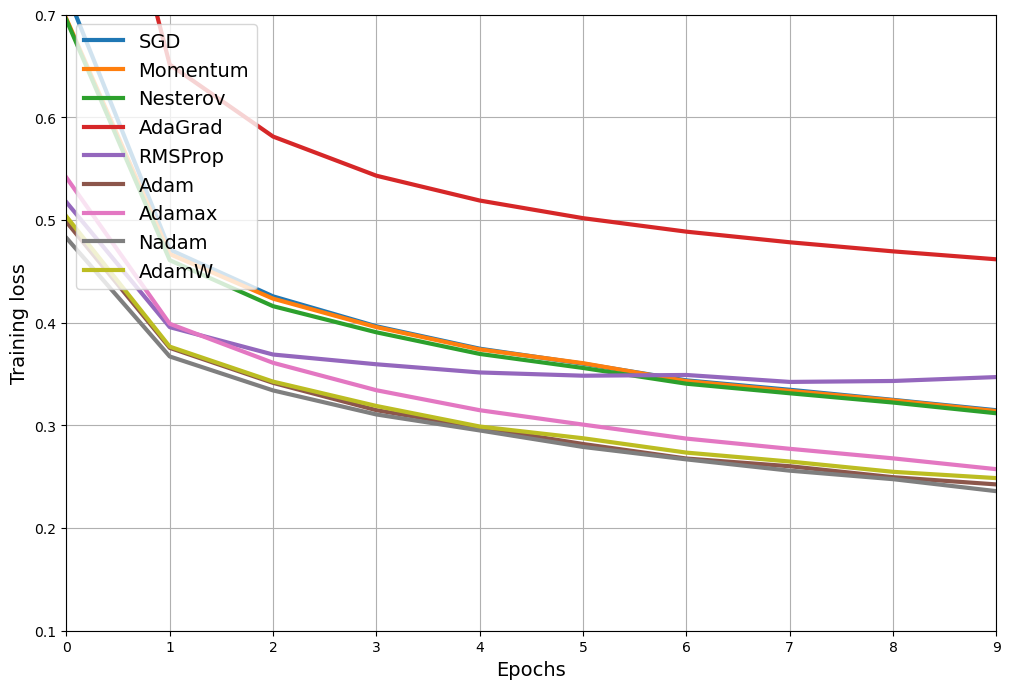

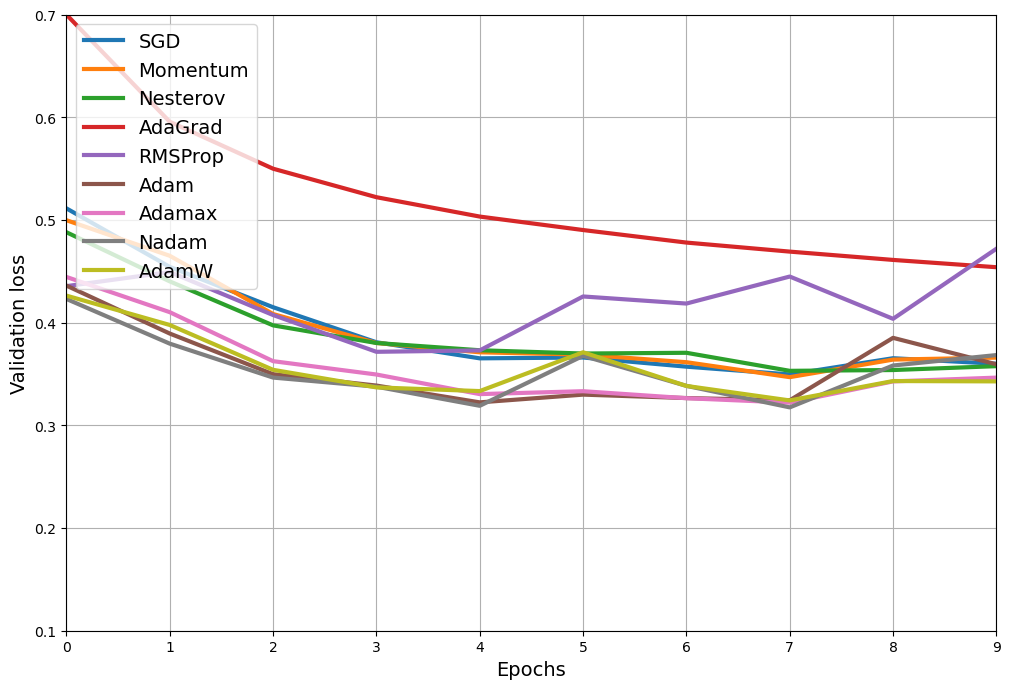

In [63]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

# 4. Learning Rate Scheduling
**Important**: the textbook learning schedule codes are based the legacy version of Keras (https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/legacy) \
If you wish to use the updated version, check https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [64]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

In [65]:
history_power_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6719 - accuracy: 0.7688 - val_loss: 0.4830 - val_accuracy: 0.8260
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4663 - accuracy: 0.8361 - val_loss: 0.4716 - val_accuracy: 0.8282
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4220 - accuracy: 0.8497 - val_loss: 0.4145 - val_accuracy: 0.8558
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3989 - accuracy: 0.8591 - val_loss: 0.3929 - val_accuracy: 0.8598
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3801 - accuracy: 0.8656 - val_loss: 0.3814 - val_accuracy: 0.8610
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3664 - accuracy: 0.8694 - val_loss: 0.3930 - val_accuracy: 0.8616
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3560 - accuracy: 0.8733 - val_loss: 0.3671 - val_accuracy:

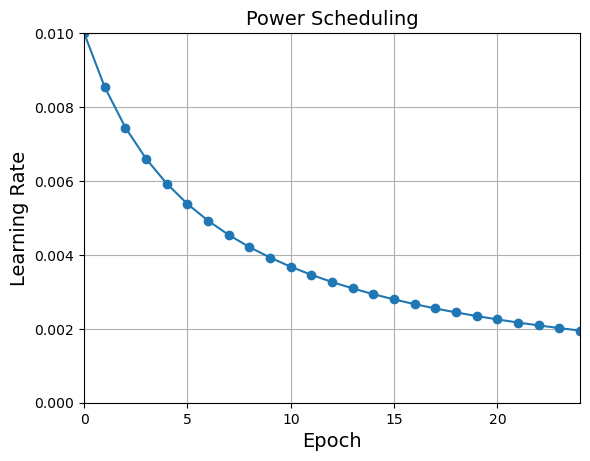

In [66]:
# extra code – this cell plots power scheduling

import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1 ** (epoch / s)```

In [67]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [68]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [69]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [70]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 2ms/step - loss: 0.6977 - accuracy: 0.7612 - val_loss: 0.4891 - val_accuracy: 0.8296 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4779 - accuracy: 0.8332 - val_loss: 0.4512 - val_accuracy: 0.8374 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4321 - accuracy: 0.8478 - val_loss: 0.4145 - val_accuracy: 0.8558 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4076 - accuracy: 0.8571 - val_loss: 0.3920 - val_accuracy: 0.8620 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3881 - accuracy: 0.8626 - val_loss: 0.3797 - val_accuracy: 0.8680 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3733 - accuracy: 0.8670 - val_loss: 0.3847 - val_accuracy: 0.8654 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 4s

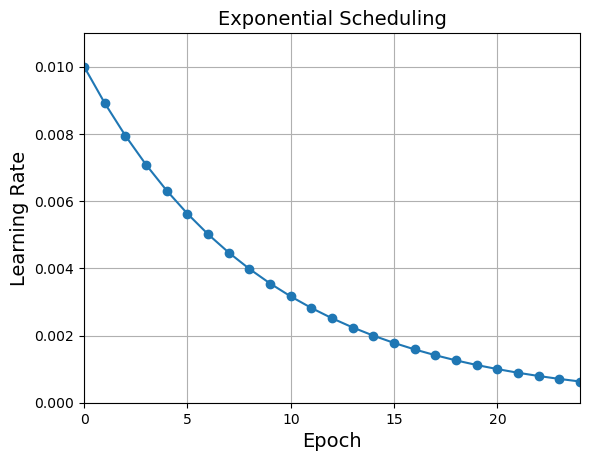

In [71]:
# extra code – this cell plots exponential scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [72]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

### Piecewise Constant Scheduling

In [73]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [74]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [75]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier
lr0 = 0.01
n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 3ms/step - loss: 0.5365 - accuracy: 0.8077 - val_loss: 0.5349 - val_accuracy: 0.7900 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4497 - accuracy: 0.8411 - val_loss: 0.4752 - val_accuracy: 0.8152 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4266 - accuracy: 0.8481 - val_loss: 0.4822 - val_accuracy: 0.8432 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4199 - accuracy: 0.8531 - val_loss: 0.4374 - val_accuracy: 0.8522 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4014 - accuracy: 0.8592 - val_loss: 0.4181 - val_accuracy: 0.8528 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3539 - accuracy: 0.8739 - val_loss: 0.4192 - val_accuracy: 0.8538 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 6s

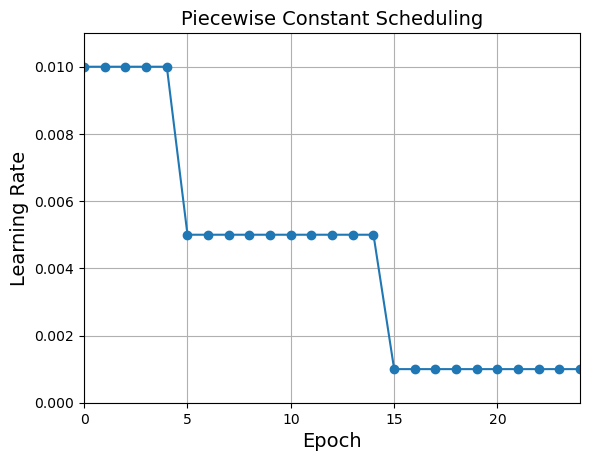

In [76]:
# extra code – this cell plots piecewise constant scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [77]:
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [78]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6968 - accuracy: 0.7607 - val_loss: 0.4879 - val_accuracy: 0.8290 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4731 - accuracy: 0.8319 - val_loss: 0.4578 - val_accuracy: 0.8350 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4243 - accuracy: 0.8471 - val_loss: 0.4223 - val_accuracy: 0.8518 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3994 - accuracy: 0.8567 - val_loss: 0.3879 - val_accuracy: 0.8638 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3777 - accuracy: 0.8644 - val_loss: 0.3774 - val_accuracy: 0.8692 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3614 - accuracy: 0.8700 - val_loss: 0.3829 - val_accuracy: 0.8668 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 4s

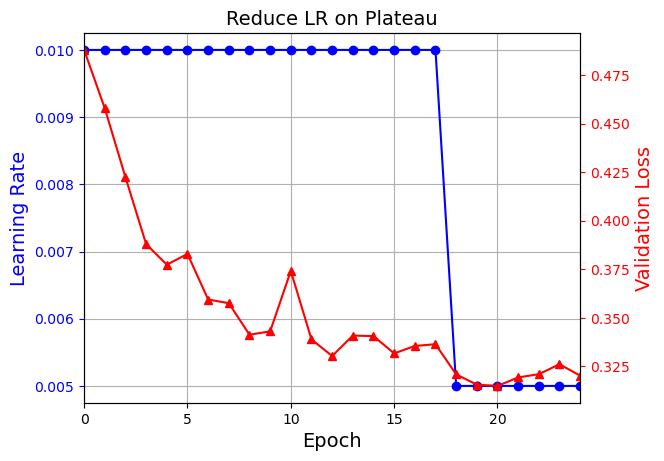

In [79]:
# extra code – this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [80]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [81]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [82]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [83]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 2s 4ms/step - loss: 151322560152454874514514130239488.0000 - accuracy: 0.4197


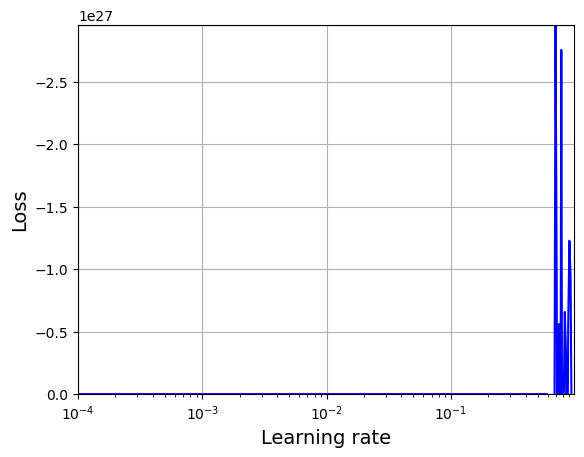

In [84]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [85]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [86]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.9595 - accuracy: 0.6865 - val_loss: 0.6170 - val_accuracy: 0.7816
Epoch 2/25
430/430 [==============================] - 2s 4ms/step - loss: 0.5784 - accuracy: 0.7972 - val_loss: 0.5037 - val_accuracy: 0.8250
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.5036 - accuracy: 0.8227 - val_loss: 0.4614 - val_accuracy: 0.8382
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4617 - accuracy: 0.8369 - val_loss: 0.4322 - val_accuracy: 0.8466
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4330 - accuracy: 0.8444 - val_loss: 0.4317 - val_accuracy: 0.8404
Epoch 6/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4071 - accuracy: 0.8536 - val_loss: 0.5336 - val_accuracy: 0.8068
Epoch 7/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3915 - accuracy: 0.8582 - val_loss: 0.4040 - val_accuracy: 0.8528
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [87]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [88]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [89]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

In [90]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 3.1038 - accuracy: 0.7782 - val_loss: 1.8516 - val_accuracy: 0.8254
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.4213 - accuracy: 0.8150 - val_loss: 1.1281 - val_accuracy: 0.8134


## Dropout

In [91]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [92]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [93]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6808 - accuracy: 0.7512 - val_loss: 0.4631 - val_accuracy: 0.8288
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5186 - accuracy: 0.8112 - val_loss: 0.4158 - val_accuracy: 0.8414
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4753 - accuracy: 0.8262 - val_loss: 0.3902 - val_accuracy: 0.8562
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4513 - accuracy: 0.8333 - val_loss: 0.3835 - val_accuracy: 0.8584
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4386 - accuracy: 0.8387 - val_loss: 0.3709 - val_accuracy: 0.8612
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4304 - accuracy: 0.8407 - val_loss: 0.3650 - val_accuracy: 0.8632
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4179 - accuracy: 0.8458 - val_loss: 0.3615 - val_accuracy:

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [94]:
model.evaluate(X_train, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.3127 - accuracy: 0.8820


[0.31269076466560364, 0.8819636106491089]

In [95]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3668 - accuracy: 0.8663


[0.3668327331542969, 0.8662999868392944]

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## Monte Carlo (MC) Dropout

In [96]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [97]:
y_probas = np.stack([model(X_test, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [98]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 128ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.02 , 0.   , 0.195, 0.   ,
        0.786]], dtype=float32)

In [99]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.067, 0.   , 0.226, 0.001,
       0.706], dtype=float32)

In [100]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.106, 0.   , 0.17 , 0.002,
       0.199], dtype=float32)

In [101]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8675

In [102]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [103]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [104]:
mc_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 784)               0         
                                                                 
 mc_dropout (MCDropout)      (None, 784)               0         
                                                                 
 dense_77 (Dense)            (None, 100)               78500     
                                                                 
 mc_dropout_1 (MCDropout)    (None, 100)               0         
                                                                 
 dense_78 (Dense)            (None, 100)               10100     
                                                                 
 mc_dropout_2 (MCDropout)    (None, 100)               0         
                                                                 
 dense_79 (Dense)            (None, 10)              

Now we can use the model with MC Dropout:

In [105]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 22ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.23, 0.  , 0.69]],
      dtype=float32)

## Max-Norm Regularization

In [106]:
dense = tf.keras.layers.Dense(
    100, activation="relu", kernel_initializer="he_normal",
    kernel_constraint=tf.keras.constraints.max_norm(1.))

In [107]:
# extra code – shows how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5549 - accuracy: 0.8009 - val_loss: 0.4389 - val_accuracy: 0.8332
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4115 - accuracy: 0.8510 - val_loss: 0.4161 - val_accuracy: 0.8470
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3785 - accuracy: 0.8619 - val_loss: 0.3684 - val_accuracy: 0.8650
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3608 - accuracy: 0.8678 - val_loss: 0.3682 - val_accuracy: 0.8638
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3481 - accuracy: 0.8705 - val_loss: 0.3634 - val_accuracy: 0.8596
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3435 - accuracy: 0.8731 - val_loss: 0.4048 - val_accuracy: 0.8600
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3340 - accuracy: 0.8759 - val_loss: 0.3941 - val_accuracy: